In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib import cm as c

#import matplotlib.pyplot.grid

cm=plt.get_cmap('nipy_spectral') # for the plotting
df=pd.read_csv('TrainSample.csv',sep=';' )

In [2]:
def lin_regr(namex,namey,df):
    model = linear_model.LinearRegression()
    nansx= np.array(np.isnan(df[namex]))
    nansy= np.array(np.isnan(df[namey]))
    nan=np.logical_or(nansx,nansy)
    df_nonans=df[np.logical_not(nan)]
    x=df_nonans[namex].values
    x=[e for e in x]
    x=np.array(x)
    y=df_nonans[namey].values
    y=[e for e in y]
    y=np.array(y)
    model.fit(x[:, np.newaxis], y)
    res= model.coef_
    print("we estimate y= ax+b, with a equals:"+ str(res))
    return res

We check how many different values zone has

In [3]:
zones_distribution=df.groupby('Zone')['API'].count()
zones_distribution

Zone
-2.542416      3
-2.021181     15
-0.978712     53
-0.457477    208
 0.063758      2
 0.584992     54
 1.106227    109
 1.627461      5
 2.148696      5
 2.669931      6
Name: API, dtype: int64

We assume that 'zone' is acutally categorical, and want to change to change its type to integers

In [4]:
z=df['Zone']
unique_vals=list(z.unique())
u=[unique_vals.index(e) for e in z]
df['Zone']=u#pd.Series(u, dtype="category")
zones_distribution=df.groupby('Zone')['API'].count()

According to the description of the variables on total.com, zone must contain somehow a location info.
Let plot zone vs surf_X and surf_Y

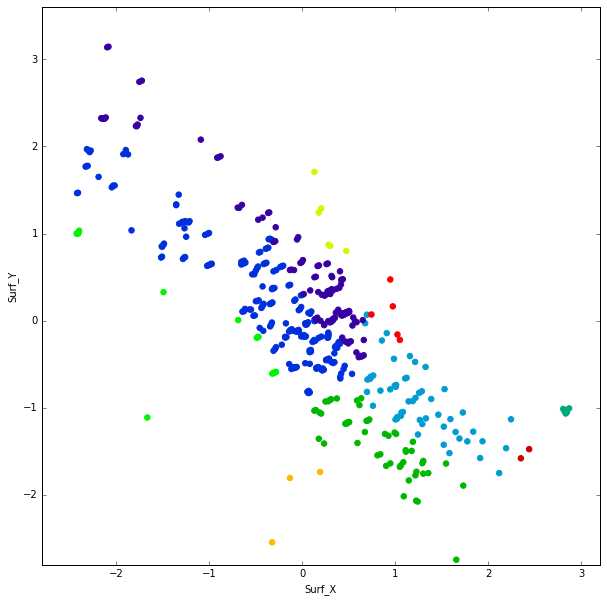

In [5]:
colors=[i/11.0 +0.13 for i in range(len(unique_vals))]  # 10 different colors for plotting
plt.figure(figsize=(10,10))
plt.xlim(-2.8,3.2)
plt.ylim(-2.8,3.6)
plt.xlabel("Surf_X")
plt.ylabel("Surf_Y")
plt.scatter(df['Surf_X'],df['Surf_Y'],color=cm([colors[e] for e in df['Zone']]),s=30)

We conclude that the feature zone is fully determined by Surf_X and Surf_Y. Zone is deviding the space into partitions.
Even zone is fully determined by other features, we do not want to delete it, the reason is shown below.
In any case, it should be treated as categorical.

### Note: the 97 lines with  the 18 missing values are only in a few zones. Also when plotting only those 97 lines we can see a pattern

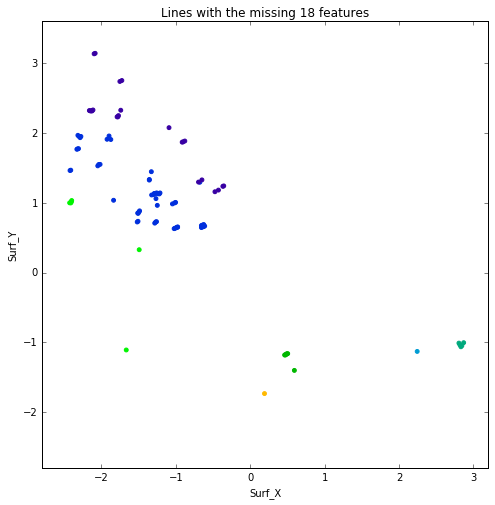

In [6]:

df2=df[ np.logical_and(np.isnan(df['Shot_Total']), np.isnan(df['Frac_Gradient (PSI/ft)'])  )] ## remove 97 lines with 18 missing
plt.figure(figsize=(8,8))
plt.xlim(-2.8,3.2)
plt.title('Lines with the missing 18 features')
plt.ylim(-2.8,3.6)
plt.xlabel("Surf_X")
plt.ylabel("Surf_Y")
plt.scatter(df2['Surf_X'],df2['Surf_Y'],color=cm([colors[e] for e in df2['Zone']]),s=15)


So the lines with the the 18 missing values have something in common. Maybe more than just the location.

## Plot Target Varibles grouped by Zone

We filter the zones with >5 records and plot the target varibles grouped by zone.
We see, that the distribution of the target variables highly depends on the zone.

Zone
0    109
1    208
2     54
3      5
4     53
5     15
6      6
7      3
8      5
9      2
Name: API, dtype: int64


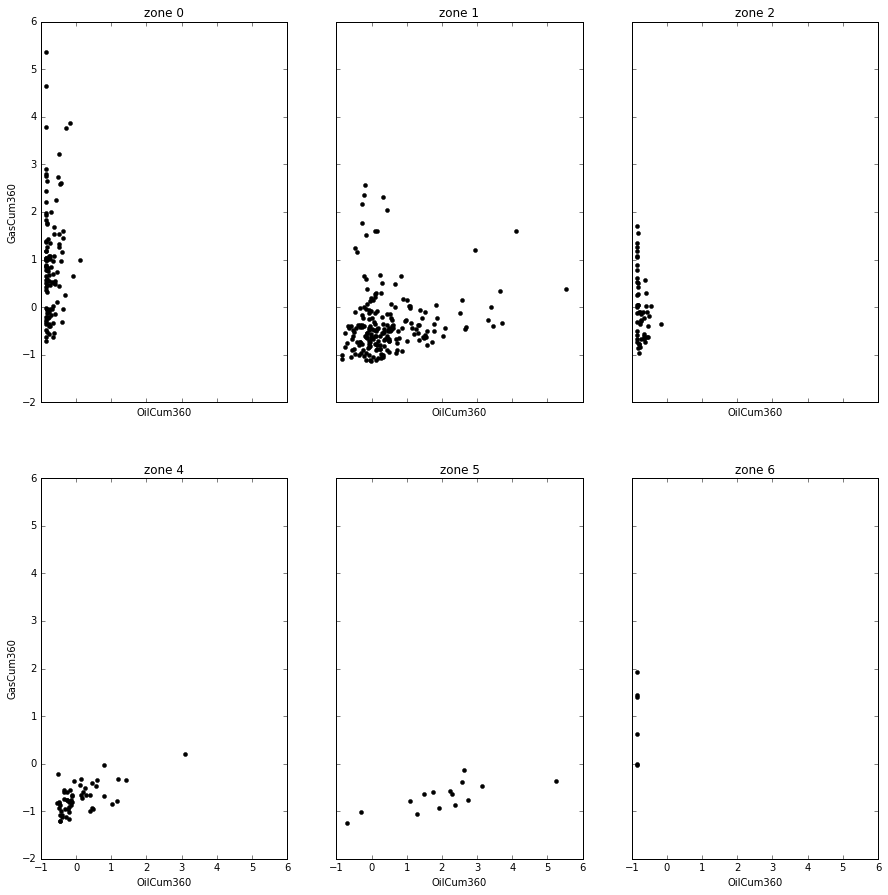

In [7]:
f, axarr = plt.subplots(ncols=3,nrows=2,sharex=True,sharey=True)
f.set_figheight(15)
f.set_figwidth(15)
print zones_distribution
big_zones=[e for e in range(len(zones_distribution)) if zones_distribution[e] >5]
#print big_zones
zones=list()
plt.figure(figsize=(12,18))
for  i in range(len(big_zones)):
    x=[ df['OilCum360'][j] for j in df.index if df['Zone'][j] ==big_zones[i]  ] 
    y=[ df['GasCum360'][j] for j in df.index if df['Zone'][j] ==big_zones[i] ]
    zones.append([x,y])
    axarr[i/3,i%3].plot( x,y,'.',ms=8,color='black')
    axarr[i/3,i%3].set_title("zone "+str(big_zones[i]))
    axarr[i/3,i%3].set_xlabel('OilCum360')
axarr[0,0].set_ylabel('GasCum360')
axarr[1,0].set_ylabel('GasCum360')

## Oil fields vs Gas fields
From the plots above, we see that apart from zone 1, each zone has either high GasCum360 and low OilCum360 or the other way round. When we plot a fitted straight line, we can see it even more clearly. 

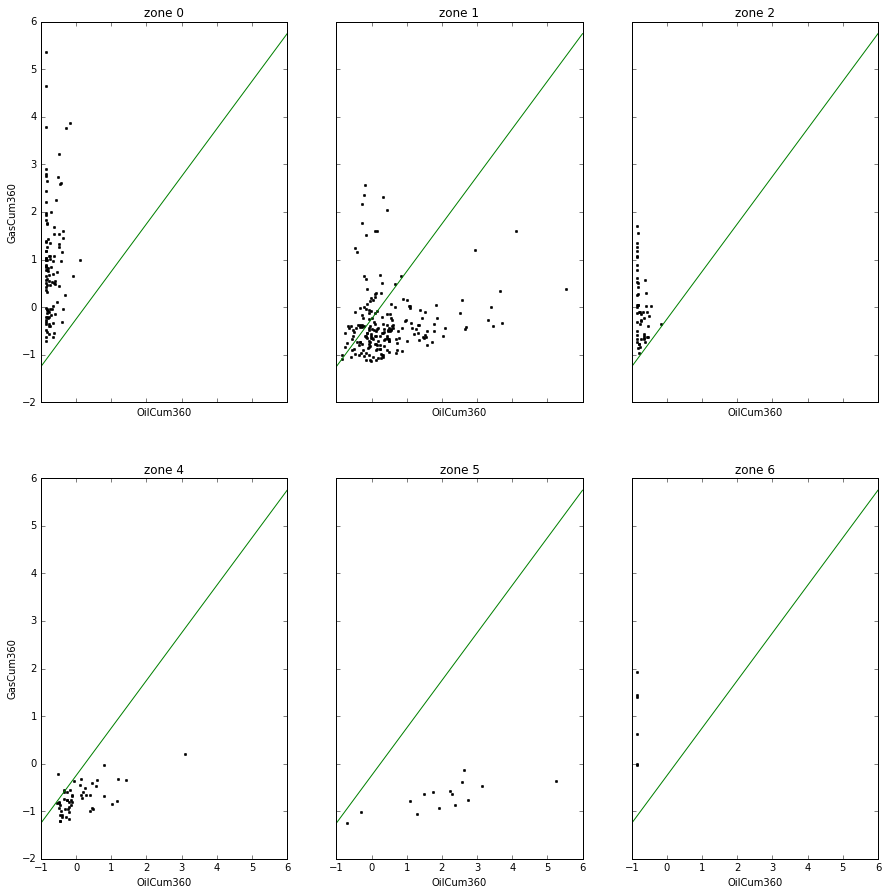

In [8]:
gx=list(np.linspace(-1,6,40))
gy=[e -0.25 for e in gx]

f2, axarr2 = plt.subplots(ncols=3,nrows=2,sharex=True,sharey=True)
f2.set_figheight(15)
f2.set_figwidth(15)

for  i in range(len(big_zones)):
    x=[ df['OilCum360'][j] for j in df.index if df['Zone'][j] ==big_zones[i]  ] 
    y=[ df['GasCum360'][j] for j in df.index if df['Zone'][j] ==big_zones[i] ]
    zones.append([x,y])
    axarr2[i/3,i%3].plot( x,y,'.',ms=5,color='black')
    axarr2[i/3,i%3].set_title("zone "+str(big_zones[i]))
    axarr2[i/3,i%3].set_xlabel('OilCum360')
    axarr2[i/3,i%3].plot(gx,gy,color="green")
axarr2[0,0].set_ylabel('GasCum360')
axarr2[1,0].set_ylabel('GasCum360')



Note that the line has the same position in every subplot. The plot above lets as assume that there is two classes of objects, one is the Oil fields ( with low gas production) and the other one is the gas fields ( with low oild production).

## What about zone 1? , it is not nicely seperated.
Yeah, zone 1 has the highest number ( 209) of objects. Some if them are clearly oil fields, others are clearly gas fields, but opposite to other zones, we have also objects that could be both and seperating them by a fitted line seems artificial here.
We have  to accecpt that the transition between oil and gas fields is continious, even if the majority of the objects can be clealry assigned to one class.

## Try  to seperate Oil fields from Gas fields

Checking wikipedia, we find this:

* ### *Natural Gas field*
        
*Natural gas originates by the same geological thermal cracking process that converts kerogen to petroleum. As a consequence, oil and natural gas are often found together. In common usage, deposits rich in oil are known as oil ##fields, and deposits rich in natural gas are called natural gas fields.*

In general, organic sediments buried in depths of 1,000 m to 6,000 m (at temperatures of 60 °C to 150 °C) generate oil, while sediments buried deeper and at higher temperatures generate natural gas. The deeper the source, the "drier" the gas (that is, the smaller the proportion of condensates in the gas).*

**So now we want to check whether the parameter Depth_TVD_PPLS  is able to seperate oil fields from gas fields.**

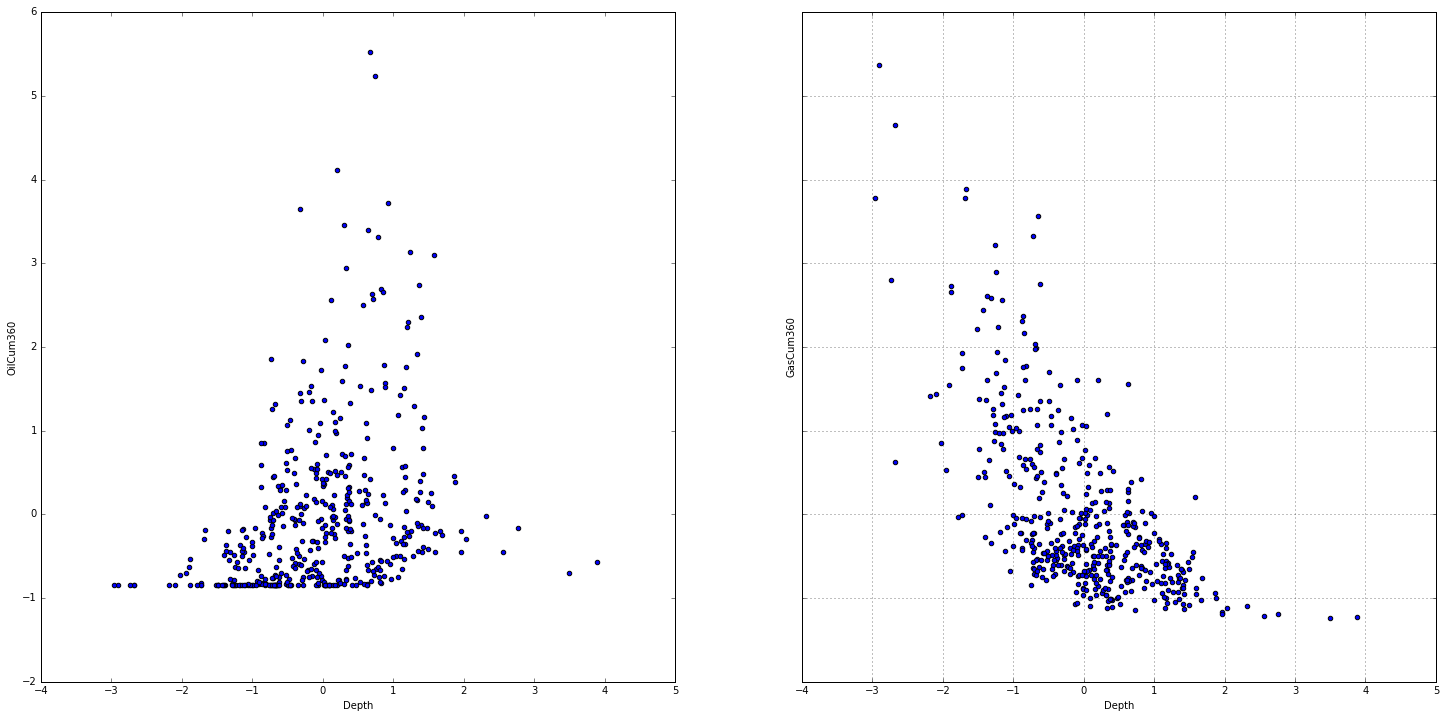

In [9]:

f3, ax3 = plt.subplots(ncols=2,sharey=True)
f3.set_figheight(12)
f3.set_figwidth(25)

ax3[0].scatter(df['Depth_TVD_PPLS (ft)'],df['OilCum360'])
plt.grid(True)
ax3[1].scatter(df['Depth_TVD_PPLS (ft)'],df['GasCum360'])

ax3[0].set_xlabel('Depth')
ax3[1].set_xlabel('Depth')
ax3[0].set_ylabel('OilCum360')
ax3[1].set_ylabel('GasCum360')



                            
                                    

Both in one plot

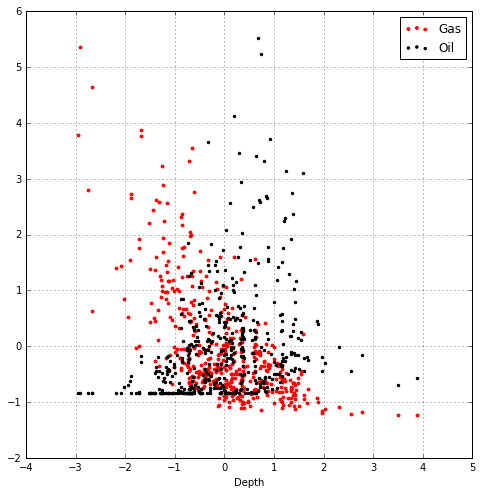

In [10]:


plt.figure(figsize=(8,8))
plt.scatter(df['Depth_TVD_PPLS (ft)'],df['GasCum360'],color='red',s=8,label='Gas')
plt.scatter(df['Depth_TVD_PPLS (ft)'],df['OilCum360'],color='black',s=6,label='Oil')
plt.legend()
plt.xlabel('Depth')
plt.grid()

We see that for depth > 1.0 ,  GasCum360 will stay below 0
            for depth < -1.0  and depth >2, OilCum360 will stay below 0
            for depth < -2 , Gas > 0.
**We try to seperate extreme Oil and extreme Gas fields at depth=0**

In [11]:
oil=df[df['Depth_TVD_PPLS (ft)']>= 0.0]
gas=df[df['Depth_TVD_PPLS (ft)']< 0.0]
print(len(oil))
print(len(gas))


227
233


 Now we plot the zones again. First for the "oil -fields"

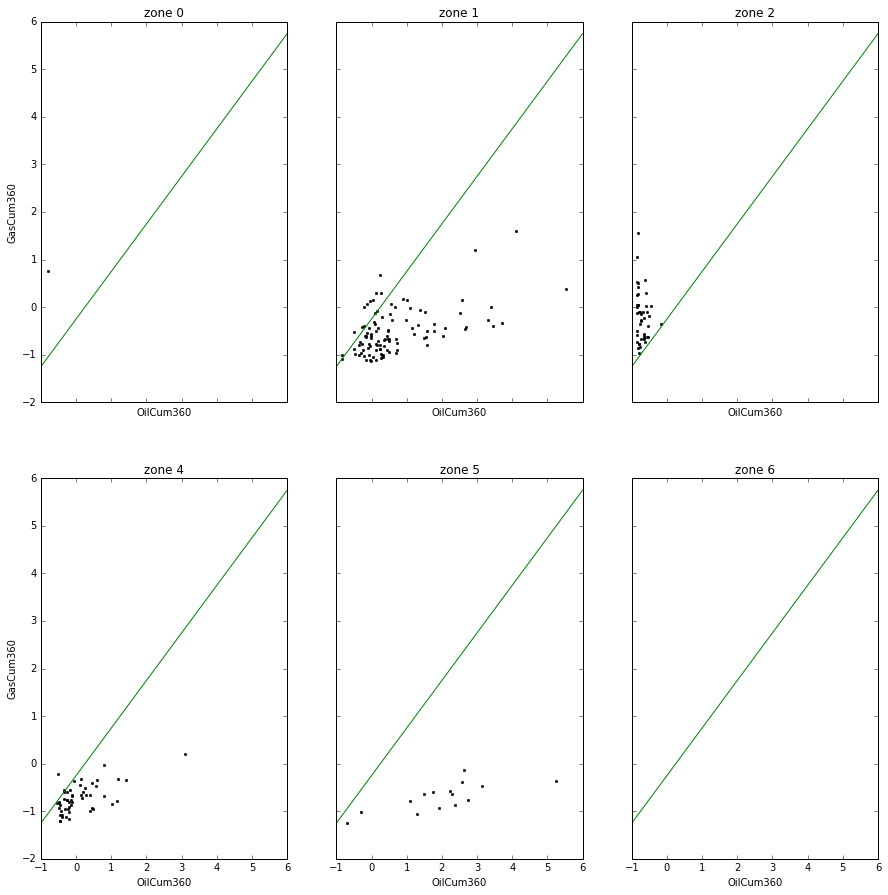

In [12]:

f4, axarr4 = plt.subplots(ncols=3,nrows=2,sharex=True,sharey=True)
f4.set_figheight(15)
f4.set_figwidth(15)

for  i in range(len(big_zones)):
    x=[ oil['OilCum360'][j] for j in oil.index if oil['Zone'][j] ==big_zones[i]  ] 
    y=[ oil['GasCum360'][j] for j in oil.index if oil['Zone'][j] ==big_zones[i] ]
    zones.append([x,y])
    axarr4[i/3,i%3].plot( x,y,'.',ms=5,color='black')
    axarr4[i/3,i%3].set_title("zone "+str(big_zones[i]))
    axarr4[i/3,i%3].set_xlabel('OilCum360')
    axarr4[i/3,i%3].plot(gx,gy,color="green")
axarr4[0,0].set_ylabel('GasCum360')
axarr4[1,0].set_ylabel('GasCum360')

It does not work so well in all the zones at the same time (see zone 2). maybe make seperate tresholds for each Zone. 
### fail, we have to split by zones also
So lets try to find the treshould just for zone 1. All the other zones are quite seperated anyway.

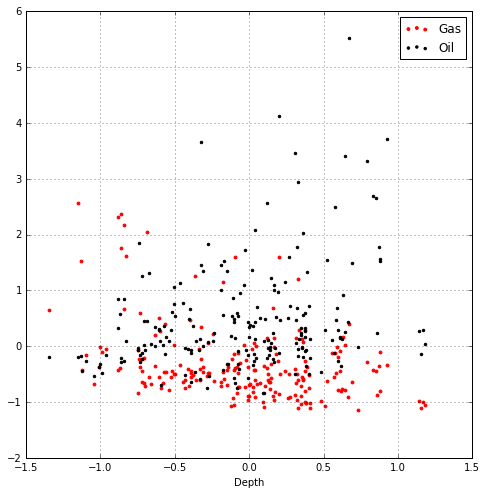

In [13]:
df3=df[df['Zone']==1]
plt.figure(figsize=(8,8))
plt.scatter(df3['Depth_TVD_PPLS (ft)'],df3['GasCum360'],color='red',s=8,label='Gas')
plt.scatter(df3['Depth_TVD_PPLS (ft)'],df3['OilCum360'],color='black',s=6,label='Oil')
plt.legend()
plt.xlabel('Depth')
plt.grid()

we split at depth= 0

104
104


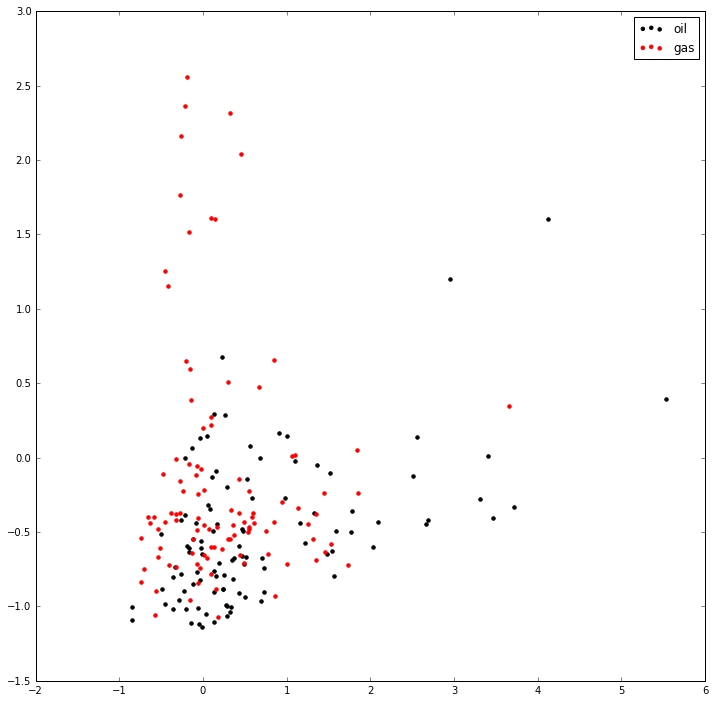

In [14]:
oil2=df3[df3['Depth_TVD_PPLS (ft)']>= 0]
gas2=df3[df3['Depth_TVD_PPLS (ft)']< 0]

print(len(oil2))
print(len(gas2))
plt.figure(figsize=(12,12))
plt.scatter(oil2['OilCum360'],oil2['GasCum360'],color='black',s=12,label='oil')
plt.scatter(gas2['OilCum360'],gas2['GasCum360'],color='red',s=12,label='gas')
plt.legend()

We have a very mixed group between oil and gas, but at least we make sure, that objects with very high oil do not end up in gas group and objects with very high gas do not end up in oil group.So we can make two different models. And avoid that the oil-field model will fit to extreme gas fields and other way round.

# Further Analysis
We want to see whether zones that are close und the surf_X surf_Y plot have a similar target space ( oil/gas)

In [30]:
p=0.6
df2=df#[~ np.isnan(df['Temperature (F)'])]
#print len(df2)
df2['OilCum360']=df2['OilCum360'] -min(df2['OilCum360'])+0.01 # to rotate the picture, explained later
df2['GasCum360']=df2['GasCum360'] -min(df2['GasCum360'])+0.01



df2['X']=np.sin(p)*(df2['Surf_X'])+np.cos(p)*(df2['Surf_Y'])
df2['Y']=np.cos(p)*(df2['Surf_X'])-np.sin(p)*(df2['Surf_Y'])

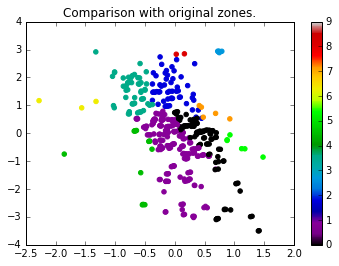

In [31]:
plt.scatter(df2['X'],df2['Y'],color=cm((df2['Zone'] )/10),cmap=cm,vmin=0, vmax=20)
m = c.ScalarMappable(cmap=cm)
m.set_array((df2['Zone'])/1)
plt.colorbar(m)
plt.title('Comparison with original zones.')
plt.show()


Zone 0 is close to zone 1 , zone 6, and zone 2.

zone 1 has a very big area. It is close to zone 0,4,5.

Zone 2 is close to zone 0 and zone 4

Zone 4 is close to zone 1, zone 2

Zone 5 is close to zone 1

zone 6 is close to zone 2

**These similarities correspond perfectly to the similarites in the feature space grouped by zone (see below)**

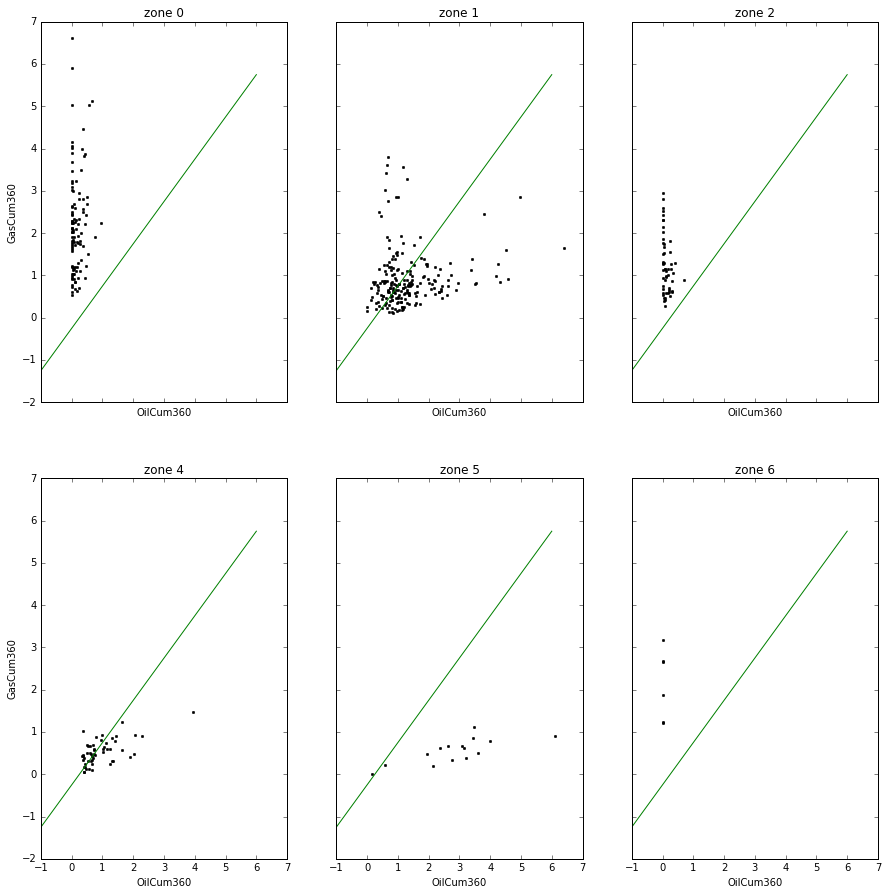

In [32]:
gx=list(np.linspace(-1,6,40))
gy=[e -0.25 for e in gx]

f2, axarr2 = plt.subplots(ncols=3,nrows=2,sharex=True,sharey=True)
f2.set_figheight(15)
f2.set_figwidth(15)

for  i in range(len(big_zones)):
    x=[ df['OilCum360'][j] for j in df.index if df['Zone'][j] ==big_zones[i]  ] 
    y=[ df['GasCum360'][j] for j in df.index if df['Zone'][j] ==big_zones[i] ]
    zones.append([x,y])
    axarr2[i/3,i%3].plot( x,y,'.',ms=5,color='black')
    axarr2[i/3,i%3].set_title("zone "+str(big_zones[i]))
    axarr2[i/3,i%3].set_xlabel('OilCum360')
    axarr2[i/3,i%3].plot(gx,gy,color="green")
axarr2[0,0].set_ylabel('GasCum360')
axarr2[1,0].set_ylabel('GasCum360')



We want to break down the similarity in feature space in one variable. Thus we define the angle in the target space.



we estimate y= ax+b, with a equals:[-0.32131475]


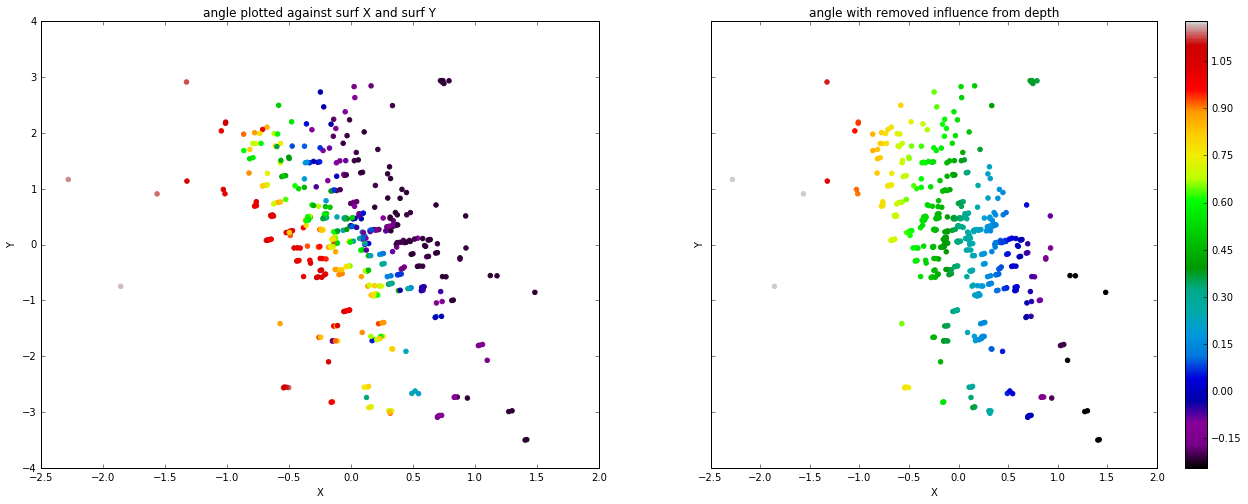

In [43]:
p=0.6
df2=df#[~ np.isnan(df['Temperature (F)'])]
#print len(df2)
df2['OilCum360']=df2['OilCum360'] -min(df2['OilCum360'])+0.01
df2['GasCum360']=df2['GasCum360'] -min(df2['GasCum360'])+0.01


df2['angle']=np.arctan(df2['GasCum360'] /df2['OilCum360'])
df2['X']=np.sin(p)*(df2['Surf_X'])+np.cos(p)*(df2['Surf_Y'])
df2['Y']=np.cos(p)*(df2['Surf_X'])-np.sin(p)*(df2['Surf_Y'])


d=1.55
f, axarr = plt.subplots(ncols=2,sharey=True)
f.set_figheight(8)
f.set_figwidth(22)
axarr[0].scatter(df2['X'],df2['Y'],color=cm((-df2['angle'] +1.6)/d),cmap=cm,vmin=0, vmax=20)
axarr[0].set_title('angle plotted against surf X and surf Y')
axarr[0].set_xlabel('X')
axarr[0].set_ylabel('Y')

a=lin_regr('Depth_TVD_PPLS (ft)','angle',df2)
m1=np.mean(df2['Depth_TVD_PPLS (ft)'])
m2=np.mean(df2['angle'])
df2['angle']=(df2['Depth_TVD_PPLS (ft)']- m1)*a+ m2


#plt.figure(figsize=(8,6))
axarr[1].scatter(df2['X'],df2['Y'],color=cm((-df2['angle'] +1.6)/d),cmap=cm,vmin=0, vmax=20)
m = c.ScalarMappable(cmap=cm)
m.set_array((df2['angle']-0.07)/d)
plt.colorbar(m)
axarr[1].set_xlabel('X')
axarr[1].set_ylabel('Y')
plt.title('angle with removed influence from depth')
plt.show()




We try to find out, how to redefine the original cells.

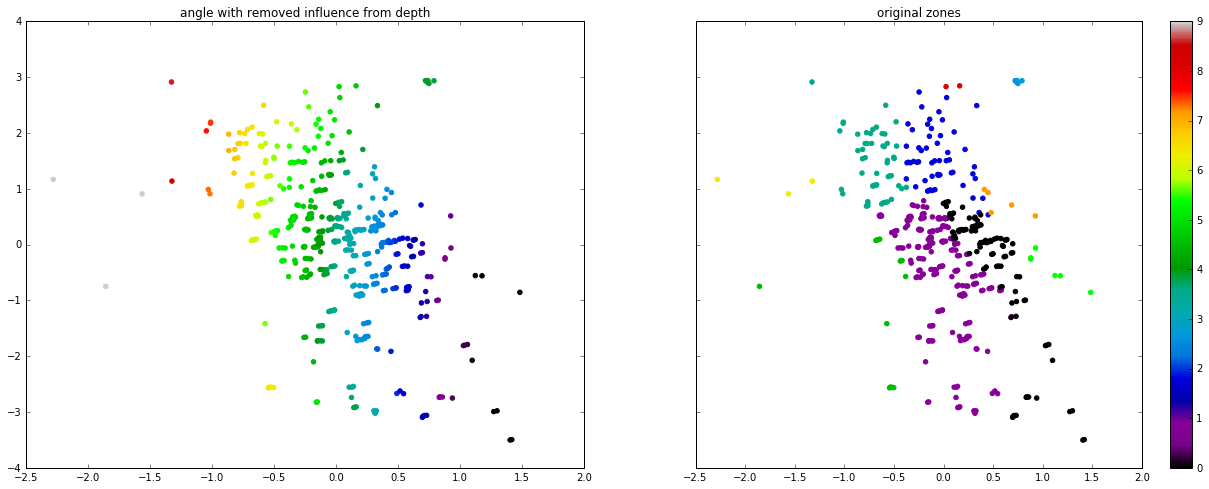

In [39]:
d=1.55
f, axarr = plt.subplots(ncols=2,sharey=True)
f.set_figheight(8)
f.set_figwidth(22)
axarr[0].scatter(df2['X'],df2['Y'],color=cm((-df2['angle'] +1.6)/d),cmap=cm,vmin=0, vmax=20)
axarr[0].set_title('angle with removed influence from depth')



#plt.figure(figsize=(8,6))
axarr[1].scatter(df2['X'],df2['Y'],color=cm((df2['Zone'] )/10),cmap=cm,vmin=0, vmax=20)
m = c.ScalarMappable(cmap=cm)
m.set_array(df2['Zone'])
plt.colorbar(m)
plt.title('original zones')
plt.show()